# 图片增广

深度学习网络自身拥有强大的表达能力，不过正因如此，网络本身需要大量甚至海量数据来驱动模型训练，否则便有极大可能陷入过拟合的窘境，可实际中， 并不是所有数据集或真实任务都能提供如ImageNet数据集一般的海量训练样 本。因此，**在实践中数据扩充(data agumentation)便成为深度模型训练的第一步。有效的数据扩充不仅能扩充训练样本数量，还能增加训练样本的多样性，一方面可避免过拟合，另一方面又会带来模型性能的提升。**

###  简单的数据扩充方式

* **水平翻转(horizontally flipping)**
* **随机抠取(random crops)**
* **尺度变换(scaling)**
* **旋转(rotating)**
* **色彩抖动(color jittering)** 
  + 指在RGB颜色空间对原有RGB色彩分布进行轻微的扰动，也可以在HSV颜色空间尝试随机改变图像原有的饱和度和明度(即改变S和V通道的值)或对色调进行微调(小范围改变该通道的值)。

更多的图片增广方式请参考这里：http://imgaug.readthedocs.io/en/latest/

需要注意的是，实际使用中还需“量体裁衣”，根据自身任务特点选择合适的数据扩充方式，而不要一股脑将所有的数据扩充方法都用到自己的任务中，因为一些数据扩充方法不仅无益于提高性能，反而还会起到相反作用，例如，若某任务为人脸识别，则图像竖直翻转不应用于数据扩充，因为上下倒置的人脸图像并不会出现在常规人脸识别任务中。

### 特殊的数据扩充方式

* **Fancy PCA**

在Alex-Net提出的论文中，他们使用了一种名为“Fancy PCA”的数据扩充方法，它首先对所有训练数据的R、G、B像素值进行主成分分析得到对应的特征向量$p_i$和特征值$\lambda_i(i=1,2,3)$,然后根据特征向量和特征值可以计算一组随机值$[p_1, p_2, p_3][\alpha_1\lambda_1, \alpha_2\lambda_2, \alpha_3\lambda_3]^T$，将其作为扰动加到原像素值中即可，其中，$\alpha_i$为取自以0为均值，标准差为0.1的高斯分布的随机值。在每经过一轮训练(一个epoch)后，$\alpha_i$将重新随机选取并重复上述操作对原像素值进行扰动，“Fancy PCA”可以近似的捕获自然图像的一个重要特性，即物体特质与光照强度和颜色变化无关”。在提高网络模型分 类准确度方面，Fancy PCA数据扩充方法在2012年的ImageNet竞赛中使得Alex-Net的top-1错误率降低了一个百分点，这个效果对于当时的模型性能来讲可以说是很大的提升。

* **监督式数据扩充**

2016年ImageNet竞赛的场景分类任务中，国内海康威视研究院提出了一种监督式——利用图像标记信息——的新型数据扩充方式。

我们知道场景分类往往依靠图像整体所蕴含的高层语义进行图像分类，而不能只以某一物体为中心来进行简单的图像分类，此时往往简单的数据扩充方式如随机抠取等效果并不好。比如，在一幅海滩的图片中，既有天空又有树，但此时如果我们随机抠取出的图片是天空和树，而由于天空和树在任何场景下都会出现，因此如果将这些随机抠取出的图片进行训练势必会影响模型的分类精度，不像“沙滩”、“大海”和“泳者”这些物体是与整个图像场景强相关。换句话说，这类一般物体对于场景分类并无很强的判别能力。

对此，可借助图像标记解决上述问题，具体而言，首先根据原数据训练一个分类的初始模型。而后，利用该模型，对每张图生成对应的特征图 (activation map)或热力图(heat map)。这张特征图可指示图像区域与场景标记间的相关概率。之后，可根据此概率映射回原图选择较强相关的图像区域作为扣取的图像块，如下图所示，按照此热力图指示，我们选取了两个强响应区域作为扣取的扩充图像块。由于一开始利用了图像标记训练了一个初始分类模型，因此这样的过程被称作 “监督式数据扩充”。同样的数据扩充方式适用于高层语义图像分类任务，如场景分类和基于图像的节日分类等问题。

<img src="../img/Chapter8-Computer-Vision/8-1.png" width="500">

下面我们使用Gluon来融入图片增广的各种方法。

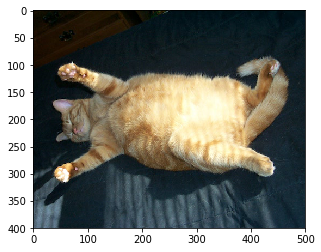

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mxnet import image

img = image.imdecode(open('cat1.jpg', 'rb').read())
plt.imshow(img.asnumpy())

** 定义一个辅助函数，给定输入图片img的aug方法，它会运行多次并画出结果 **

** 有关python中单星号和多星号的用法，可以参考这篇文章：** https://www.qingsword.com/qing/python-12.html

In [2]:
from mxnet import nd
import utils

def show_images(imgs, nrows, ncols, figsize=None):
    if not figsize:
        figsize = (nrows, ncols)
    _, figs = plt.subplots(nrows, ncols, figsize=figsize)
    for i in range(nrows):
        for j in range(ncols): 
            figs[i][j].imshow(imgs[ncols*i + j].asnumpy())
            figs[i][j].axes.get_xaxis().set_visible(False)
            figs[i][j].axes.get_yaxis().set_visible(False)
    plt.show()

def apply(img, aug, n=3):
    # 将图片类型都转成浮点数
    # 原因一是aug需要float类型数据来方便做变化
    # 原因二是有些aug直接通过copy数据来改写输入，而不是新建输出来获取性能的提升
    X = [aug(img.astype('float32')) for _ in range(n*n)]
    # 有些aug不保证输入时合法值，所以做一次clip
    # 显示浮点图片时imshow要求输入在[0,1]之间
    Y = nd.stack(*X).clip(0, 255) / 255
    show_images(Y, n, n, figsize=(8,8)) 

### 水平翻转

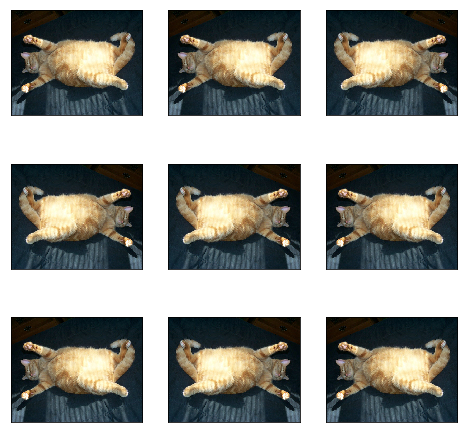

In [3]:
aug = image.HorizontalFlipAug(.5)
apply(img, aug)

### 随机抠取(长宽比不做变化)

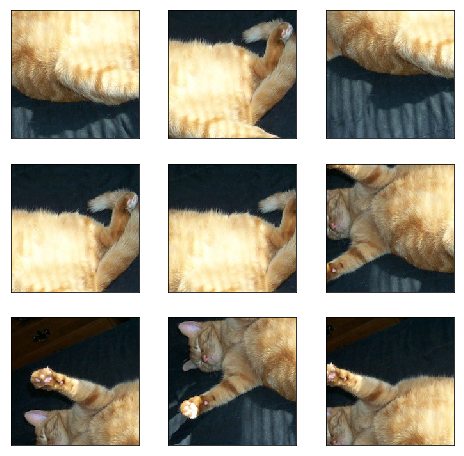

In [4]:
aug = image.RandomCropAug([200, 200])
apply(img, aug)

### 随机裁剪(长宽比做变化)

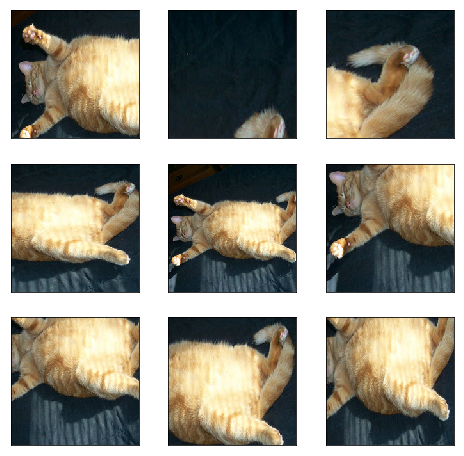

In [5]:
'''
size : tuple of (int, int)
    Size of the crop formatted as (width, height).
min_area : int
    Minimum area to be maintained after cropping
ratio : tuple of (float, float)
    Aspect ratio range as (min_aspect_ratio, max_aspect_ratio)
'''
aug = image.RandomSizedCropAug((200,200), 0.1, (0.5, 2))
apply(img, aug)

### 中心裁剪

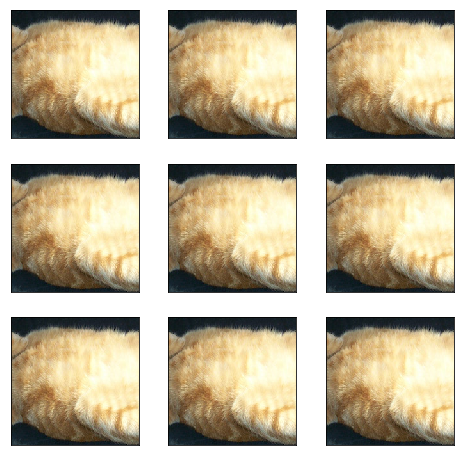

In [6]:
aug = image.CenterCropAug((200,200))
apply(img, aug)

### 色彩抖动

### 亮度变化

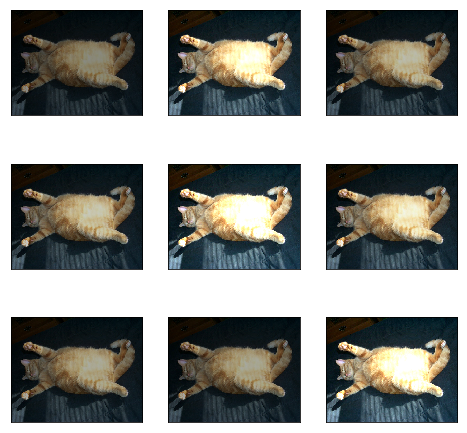

In [7]:
# 随机将亮度增加或减少0-0.5被之间的一个量
aug = image.BrightnessJitterAug(.5)
apply(img, aug)

### 色调变化

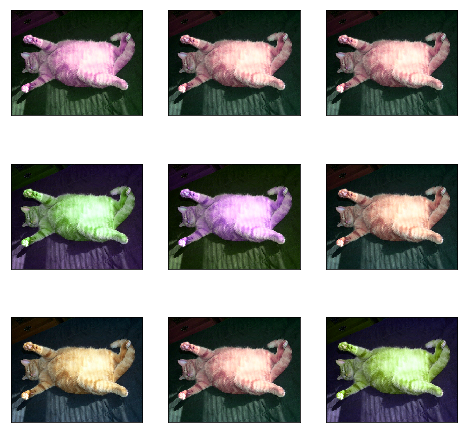

In [8]:
aug = image.HueJitterAug(.5)
apply(img, aug)

## 使用CIFAR-10和ResNet18的图片增广

我们已经修改了[util.py](http://www.angzz.top:8888/edit/Liang-Notebook/MXNet-Gluon-Ang/Chapter8-Computer-Vision/utils.py)中的``load_dataset``函数为图片施加增广。

In [9]:
train_augs = [
    image.HorizontalFlipAug(.5),
    image.RandomCropAug((28, 28)),
]

test_augs = [
    image.CenterCropAug((28, 28))
]

batch_size = 64
train_data, test_data = utils.load_dataset(batch_size, data_type='cifar10', 
                                           train_augs=train_augs, test_augs=test_augs)

d:\liang-jupyter\liang-jupyter\lib\site-packages\mxnet\gluon\data\vision\datasets.py:159: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(fin.read(), dtype=np.uint8).reshape(-1, 3072+1)


(64, 3, 28, 28)


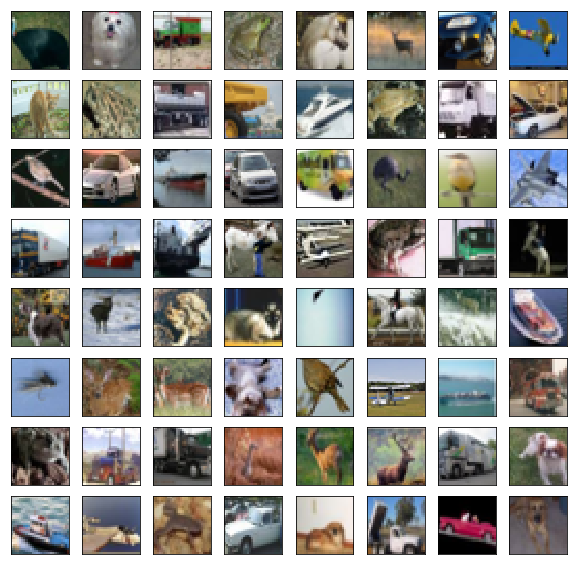

In [10]:
for imgs, _ in train_data:
    print(imgs.shape)
    break
    
show_images(nd.transpose(imgs, axes=(0,2,3,1)), 8, 8, figsize=(10,10))

## 训练

这里我们主要是对比使用增广和不适用增广给模型精度带来的差别。

In [11]:
import mxnet as mx
import numpy as np

import utils

from mxnet import nd
from mxnet import gluon
from mxnet import autograd

ctx = mx.cpu()

In [12]:
def BN_ReLU_CONV(channels, kernel_size, strides=1, padding=0):
    net = gluon.nn.HybridSequential()
    with net.name_scope():
        net.add(
            gluon.nn.BatchNorm(axis=1),
            gluon.nn.Activation('relu'),
            gluon.nn.Conv2D(channels, kernel_size=kernel_size, strides=strides, padding=padding)
        )
    return net

def BN_CONV(channels, kernel_size, strides=1, padding=0):
    net = gluon.nn.HybridSequential()
    with net.name_scope():
        net.add(
            gluon.nn.BatchNorm(axis=1),
            gluon.nn.Conv2D(channels, kernel_size=kernel_size, strides=strides, padding=padding)
        )
    return net

# Hybridize版本的Residual
class Residual(gluon.HybridBlock):
    def __init__(self, channels, shape_inc=False, **kwargs):
        super().__init__(**kwargs)
        self.shape_inc = shape_inc
        self.residual = gluon.nn.HybridSequential()
        strides = 2 if shape_inc else 1
        self.residual.add(
            BN_CONV(channels, kernel_size=3, strides=strides, padding=1),
            gluon.nn.Activation('relu'),
            BN_CONV(channels, kernel_size=3, padding=1)
        )
        if self.shape_inc: 
            # 如果channel增加一倍，则feature map size减半，这是为了维持算法复杂度，下面的这个conv是对输入X减半
            self.cutdown_conv = BN_CONV(channels, kernel_size=1, strides=strides)
            
    def hybrid_forward(self, F, X):
        out = self.residual(X)
        if self.shape_inc:
            X = self.cutdown_conv(X)
        return F.relu(out + X)

In [13]:
# test
residual = Residual(128, shape_inc=False)
residual.initialize(ctx=ctx, init=mx.init.Xavier())
residual.hybridize()
X = nd.random.uniform(shape=(32, 128, 28, 28), ctx=ctx)
residual(X).shape

(32, 128, 28, 28)

In [14]:
def ResNet18(num_classes):
    resnet = gluon.nn.HybridSequential()
    with resnet.name_scope():
        resnet.add(
            BN_CONV(64, kernel_size=3, padding=1),
            gluon.nn.Activation('relu'),
            gluon.nn.MaxPool2D(pool_size=3, strides=2),
            Residual(64),
            Residual(64),
            Residual(128, shape_inc=True),
            Residual(128),
            Residual(256, shape_inc=True),
            Residual(256),
            gluon.nn.GlobalAvgPool2D(), # 全局平均池化层
            gluon.nn.Dense(num_classes),
        )
    return resnet

In [15]:
# test
resnet18 = ResNet18(10)
resnet18.initialize(ctx=ctx)
resnet18.hybridize()
X = nd.random.uniform(shape=(1, 3, 34, 34), ctx=ctx)
resnet18(X).shape

(1, 10)

In [16]:
from time import time

def train(train_data, test_data, net, batch_size, num_epochs, trainer, loss, ctx):
    niter = 0
    moving_loss = .0
    smoothing_constant = 0.9
    
    print("Start Training On:", ctx)
    for epoch in range(num_epochs):
        start = time()
        for data, label in train_data:
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            with autograd.record():
                output = net(data)
                L = loss(output, label)
            L.backward()
            trainer.step(batch_size)
            
            niter += 1
            curr_loss = nd.mean(L).asscalar()
            moving_loss = smoothing_constant * moving_loss + (1-smoothing_constant) * curr_loss
            estimated_loss = moving_loss / (1 - smoothing_constant**niter)
            
        train_acc, train_loss = utils.evaluate_accuracy_gluon(train_data, net, ctx, loss_avg=True)
        test_acc, test_loss = utils.evaluate_accuracy_gluon(test_data, net, ctx, loss_avg=True)
        print("Epoch %d, Moving Train Loss %.5f, Train Loss %.5f, Test Loss %.5f, Train acc %.5f, Test acc %.5f, Time Consume %.5f."
             % (epoch, estimated_loss, train_loss, test_loss, train_acc, test_acc, (time()-start)))

In [17]:
# 我们整理train方法实现复用
def train_aug(train_augs, test_augs, num_epochs, batch_size, learning_rate):
    softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
    train_data, test_data = utils.load_dataset(batch_size, data_type='cifar10', 
                                              train_augs=train_augs, test_augs=test_augs)
    ctx = mx.gpu()
    num_classes = 10
    resnet18 = utils.ResNet18(num_classes)
    resnet18.collect_params().initialize(ctx=ctx, init=mx.init.Xavier())
    resnet18.hybridize()
    
    trainer = gluon.Trainer(resnet18.collect_params(), 'sgd', {'learning_rate': learning_rate})
    train(train_data, test_data, resnet18, batch_size, num_epochs, trainer, softmax_cross_entropy, ctx)

使用图片增广来训练，可以看到模型不易过拟合

In [18]:
train_aug(train_augs, test_augs, num_epochs=10, batch_size=64, learning_rate=.1)

d:\liang-jupyter\liang-jupyter\lib\site-packages\mxnet\gluon\data\vision\datasets.py:159: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(fin.read(), dtype=np.uint8).reshape(-1, 3072+1)


Start Training On: gpu(0)
Epoch 0, Moving Train Loss 1.06646, Train Loss 1.01831, Test Loss 1.02494, Train acc 0.63842, Test acc 0.63110, Time Consume 92.17200.
Epoch 1, Moving Train Loss 0.85587, Train Loss 0.88999, Test Loss 0.91246, Train acc 0.68672, Test acc 0.68310, Time Consume 91.18600.
Epoch 2, Moving Train Loss 0.73677, Train Loss 0.66064, Test Loss 0.69443, Train acc 0.76960, Test acc 0.75820, Time Consume 94.11600.
Epoch 3, Moving Train Loss 0.74161, Train Loss 0.60975, Test Loss 0.65524, Train acc 0.78462, Test acc 0.77310, Time Consume 91.68700.
Epoch 4, Moving Train Loss 0.59414, Train Loss 0.56456, Test Loss 0.62004, Train acc 0.80258, Test acc 0.78440, Time Consume 89.66800.
Epoch 5, Moving Train Loss 0.58659, Train Loss 0.46951, Test Loss 0.55431, Train acc 0.83658, Test acc 0.80760, Time Consume 89.19500.
Epoch 6, Moving Train Loss 0.53559, Train Loss 0.45520, Test Loss 0.55604, Train acc 0.84132, Test acc 0.81060, Time Consume 89.83500.
Epoch 7, Moving Train Loss 0.

在不使用图片增广的情况下，可以看到明显的过拟合现象

In [19]:
train_aug(train_augs=None, test_augs=None, num_epochs=10, batch_size=64, learning_rate=.1)

d:\liang-jupyter\liang-jupyter\lib\site-packages\mxnet\gluon\data\vision\datasets.py:159: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(fin.read(), dtype=np.uint8).reshape(-1, 3072+1)


Start Training On: gpu(0)
Epoch 0, Moving Train Loss 1.02668, Train Loss 0.83817, Test Loss 0.92717, Train acc 0.70634, Test acc 0.67000, Time Consume 83.98400.
Epoch 1, Moving Train Loss 0.79036, Train Loss 0.58383, Test Loss 0.76345, Train acc 0.79974, Test acc 0.73300, Time Consume 84.20700.
Epoch 2, Moving Train Loss 0.51124, Train Loss 0.44185, Test Loss 0.71354, Train acc 0.84862, Test acc 0.75410, Time Consume 83.73600.
Epoch 3, Moving Train Loss 0.44265, Train Loss 0.27504, Test Loss 0.64357, Train acc 0.90864, Test acc 0.78290, Time Consume 83.17500.
Epoch 4, Moving Train Loss 0.33781, Train Loss 0.24179, Test Loss 0.73130, Train acc 0.91500, Test acc 0.77140, Time Consume 83.96300.
Epoch 5, Moving Train Loss 0.23154, Train Loss 0.16525, Test Loss 0.76559, Train acc 0.94308, Test acc 0.78230, Time Consume 85.94300.
Epoch 6, Moving Train Loss 0.22848, Train Loss 0.13014, Test Loss 0.83576, Train acc 0.95448, Test acc 0.77380, Time Consume 83.40700.
Epoch 7, Moving Train Loss 0.